# Electricity Price Prediction

In [1]:
# Libraries
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

## Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.


In [2]:
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [3]:
X_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [4]:
Y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


## Exploratory Data Analysis and Pre-Processing

Let's see how big our training and test datasets are and the types of values they contain.

In [5]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (1494, 35)
X_test shape:  (654, 35)


In [6]:
X_train.dtypes.value_counts()

float64    32
int64       2
object      1
dtype: int64

Let's look at the distribution of the variables.

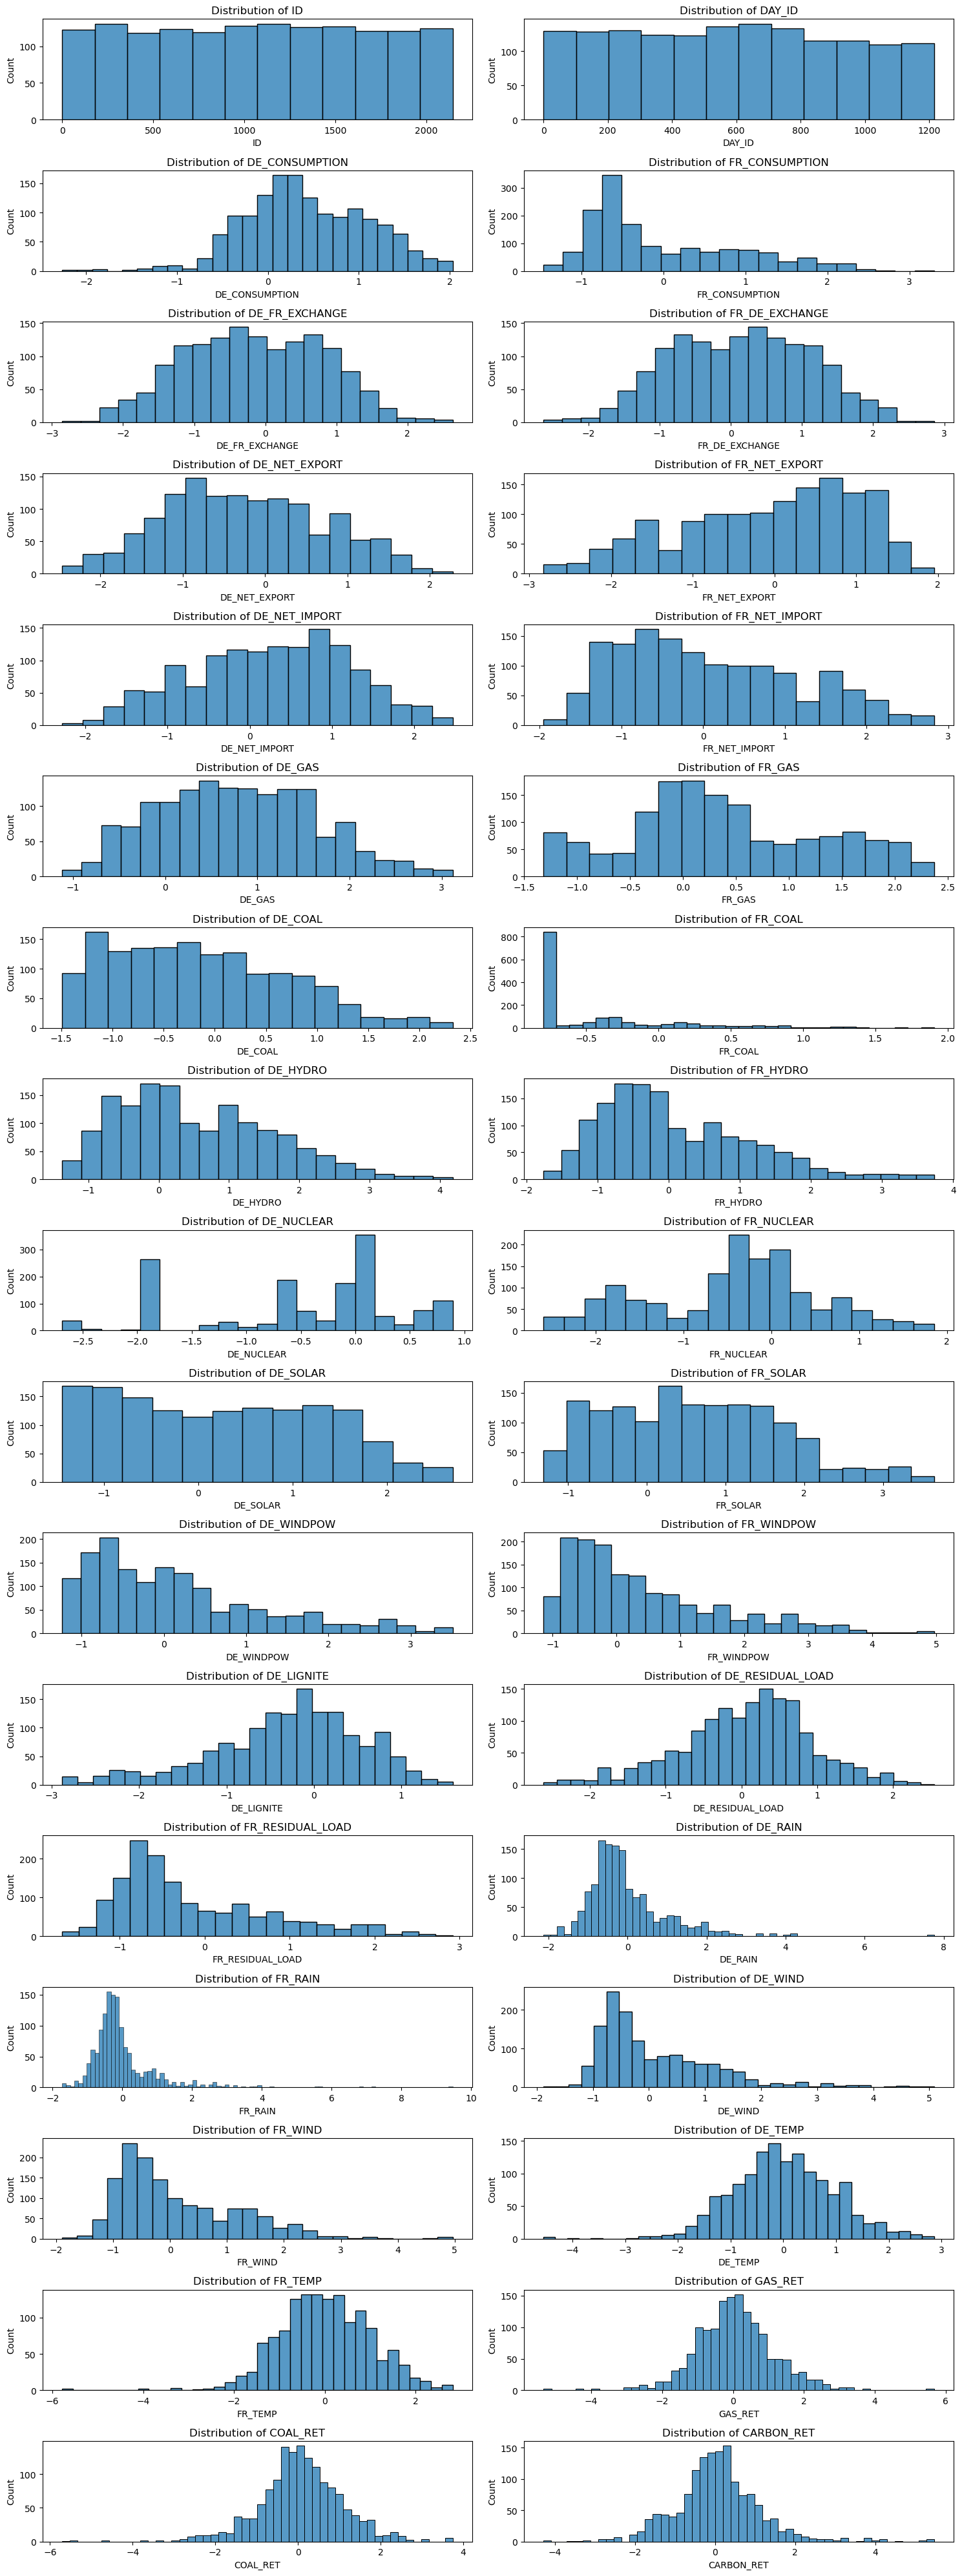

In [7]:
all_columns = X_train.select_dtypes(['float64', 'int64']).columns
num_rows = 17
num_cols = 2

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 40)) 
axes = axes.flatten()

for i, col in enumerate(all_columns):
    sns.histplot(X_train[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

Most of the variables seem to be normally distributed (therefore we do not need to normalize them) and some variables are slightly skewed.

#### Label encoding the country column

As the country column is the only categorical column, we will need to encode it.

In [8]:
X_train['COUNTRY_ID'] = X_train['COUNTRY'].apply(lambda x: 0 if x == 'DE' else 1)

### Missing values

In [9]:
#Count the missing value
X_train.isnull().sum()
#show only the one that is not 0
X_train.isnull().sum()[X_train.isnull().sum() > 0]

DE_FR_EXCHANGE     25
FR_DE_EXCHANGE     25
DE_NET_EXPORT     124
FR_NET_EXPORT      70
DE_NET_IMPORT     124
FR_NET_IMPORT      70
DE_RAIN            94
FR_RAIN            94
DE_WIND            94
FR_WIND            94
DE_TEMP            94
FR_TEMP            94
dtype: int64

As we can see, some columns have the same number of missing values:
- DE_FR_EXCHANGE = FR_DE_EXCHANGE
- DE_NET_EXPORT = DE_NET_IMPORT
- FR_NET_EXPORT = FR_NET_IMPORT

Later, we will observe that these columns are highly correlated.

#### We try 3 different methods for missing values and see how this will impact model results.

1. We will remove the rows with missing values.

In [10]:
Xtrain_copy = X_train.copy()
X_train_dropnull = Xtrain_copy.dropna()
print("The new size", X_train_dropnull.shape)

The new size (1276, 36)


2. Replacing the missing value to 0

In [11]:
# fill the missing value with 0
X_train_fillna = Xtrain_copy.fillna(0)

3. Change the null value to moving average for different country

In [12]:
# replace the missing value with running average according to the DAY_ID for fr_df and de_df
fr_df = X_train[X_train['COUNTRY'] == 'FR']
de_df = X_train[X_train['COUNTRY'] == 'DE']

fr_df = fr_df.sort_values(by='DAY_ID')
de_df = de_df.sort_values(by='DAY_ID')

def fill_with_running_avg(df):
    df.iloc[0] = df.iloc[0].fillna(0)
    
    for column in df.columns[3:]:
        if df[column].dtype == 'float64' or df[column].dtype == 'int64':
            # Calculate the running average excluding the first row
            running_average = df[column].expanding(min_periods=2).mean()
            # Fill missing values with the running average
            df[column] = df[column].fillna(running_average)
    return df

france_df_filled = fill_with_running_avg(fr_df)
germany_df_filled = fill_with_running_avg(de_df)
    
# check the missing value
print('FR missing values:', france_df_filled.isnull().sum().sum())
print('DE missing values:', germany_df_filled.isnull().sum().sum())

FR missing values: 0
DE missing values: 0


In [13]:
france_df_filled.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_ID
742,1057,0,FR,0.048418,-0.465067,-0.079296,0.079296,0.000000,0.650577,0.000000,...,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,1
1211,1179,1,FR,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,...,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,1
1408,1327,2,FR,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1
329,2016,3,FR,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,1
512,2047,5,FR,-0.297850,-0.470371,0.144615,-0.144615,-1.208286,-1.811403,1.208286,...,-1.374757,-0.790071,0.333817,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870,1


In [14]:
# merge fr_df and de_df together
X_train_merge = pd.concat([fr_df, de_df])
X_train_merge = X_train_merge.drop('COUNTRY', axis=1)
print("The new size of X_train_merge: ", X_train_merge.shape)

X_train_merge.head()

The new size of X_train_merge:  (1494, 35)


,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_ID
742,1057,0,0.048418,-0.465067,-0.079296,0.079296,0.000000,0.650577,0.000000,-0.650577,...,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,1
1211,1179,1,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,-0.778627,...,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,1
1408,1327,2,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,...,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1
329,2016,3,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,...,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,1
512,2047,5,-0.297850,-0.470371,0.144615,-0.144615,-1.208286,-1.811403,1.208286,1.811403,...,-1.374757,-0.790071,0.333817,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870,1


## Repeating the preprocessing for X_test

In [15]:
X_test_copy = X_test.copy()

# Label encoding the country column
X_test['COUNTRY_ID'] = X_test['COUNTRY'].apply(lambda x: 0 if x == 'DE' else 1)
print("The new size of X_test_copy: ", X_test.shape)

# 1. Dropping the null Values
X_test_dropnull = X_test_copy.dropna()

# 2. Replacing the missing value to 0
X_test_fillna = X_test_copy.fillna(0)

# 3. Change the null value to moving average for different country
fr_test_df = X_test[X_test['COUNTRY'] == 'FR']
de_test_df = X_test[X_test['COUNTRY'] == 'DE']

fr_test_df = fr_test_df.sort_values(by='DAY_ID')
de_test_df = de_test_df.sort_values(by='DAY_ID')

france_test_df_filled = fill_with_running_avg(fr_test_df)
germany_test_df_filled = fill_with_running_avg(de_test_df)

# Merging the two data frames
X_test_merge = pd.concat([germany_test_df_filled, france_test_df_filled])
X_test_merge = X_test_merge.drop('COUNTRY', axis=1)
X_test_merge.head()

The new size of X_test_copy:  (654, 36)


,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_ID
231,410,4,0.944117,0.203547,0.372743,-0.372743,0.656335,0.519380,-0.656335,-0.519380,...,-0.900802,-0.359430,-0.614570,-0.734964,1.192221,0.701597,-0.357747,0.696316,-0.426880,0
570,562,6,0.120788,-0.744840,-1.195940,1.195940,-1.670709,1.164429,1.670709,-1.164429,...,3.127472,0.149032,0.324280,1.119383,-0.288148,-0.894852,2.213681,0.352223,0.518026,0
199,750,9,1.056973,0.535641,0.989874,-0.989874,0.091679,-1.072153,-0.091679,1.072153,...,0.050956,-0.647654,0.666003,1.848971,0.007103,-0.182161,0.021228,0.484992,0.202597,0
202,802,13,-0.138870,-0.702079,-0.521880,0.521880,-1.067974,-0.670168,1.067974,0.670168,...,0.410745,-0.139418,0.573454,0.498127,-0.571953,-0.349293,-0.548502,0.578269,-0.831399,0
203,504,24,0.143362,-0.524899,-1.030414,1.030414,-1.005184,0.832404,1.005184,-0.832404,...,0.672093,-0.249368,0.237292,0.682879,0.084806,-0.181177,0.232096,-0.078845,0.190155,0


### Correlation Analysis

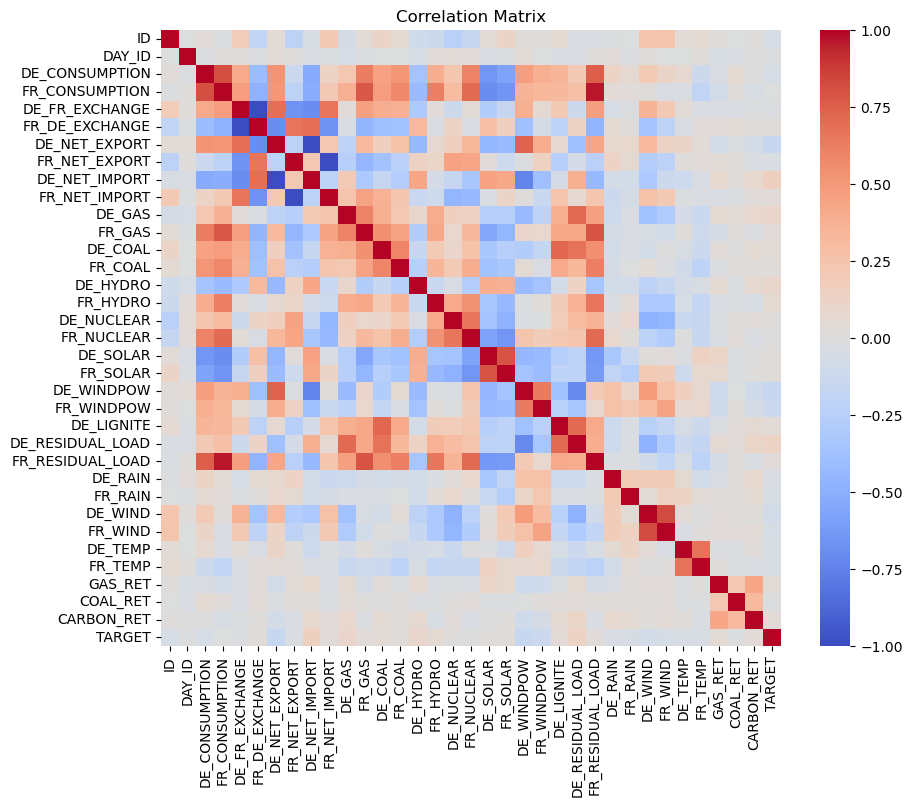

In [16]:
all_df = pd.merge(X_train_merge, Y_train, on='ID', how='left')
numerical_columns = all_df.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_columns.drop(['COUNTRY_ID'], axis=1)
correlation_matrix = numerical_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

We consider +/-0.8 to be a high correlation. We filter for these correlations below to see which columns are highly correlated.

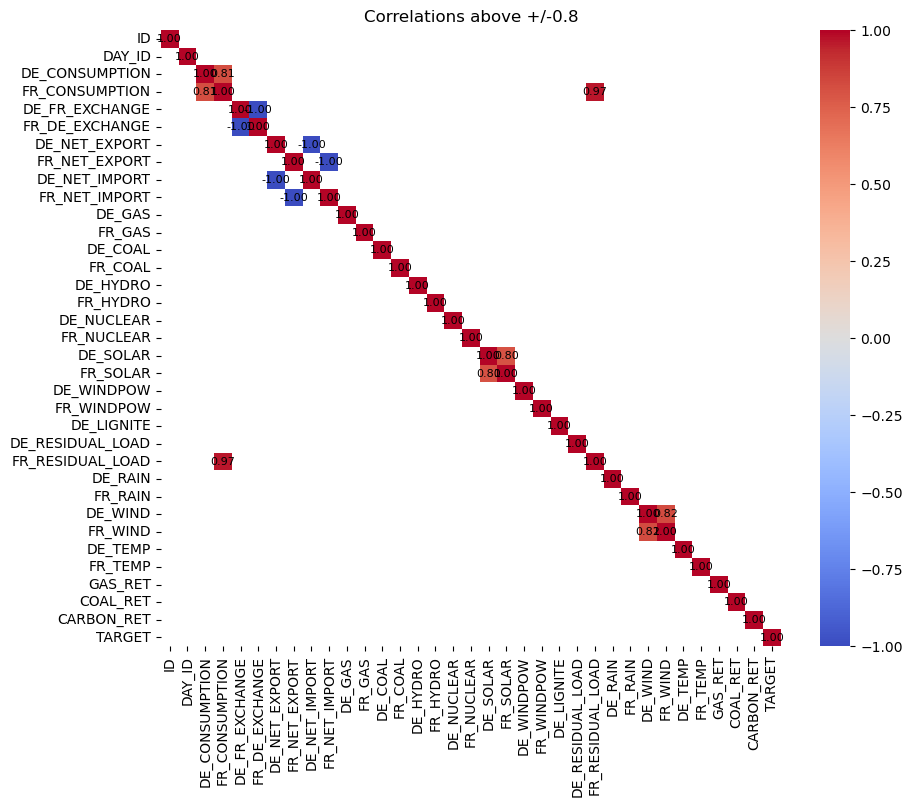

In [17]:
# Filter correlations above 0.8 
high_correlations = correlation_matrix[correlation_matrix.abs() > 0.8]
plt.figure(figsize=(10, 8))
annot_kws = {"ha": 'center', "va": 'center', "fontsize": 8, "color": 'black'}
sns.heatmap(high_correlations, annot=True, cmap='coolwarm', fmt=".2f", annot_kws=annot_kws)
plt.title('Correlations above +/-0.8')
plt.show()

From the correlation plot, we observe the following correlations:
- FR_CONSUMPTION and FR_RESIDUAL_LOAD
- FR_CONSUMPTION and DE_CONSUMPTION 
- DE_FR_EXCHANGE and FR_DE_EXCHANGE
- DE_NET_IMPORT and DE_NET_EXPORT
- FR_NET_IMPORT and FR_NET_EXPORT
- DE_SOLAR and FR_SOLAR
- DE_WIND and FR_WIND

Indeed it is interesting to note the following relationships between the variables:
- FR/DE_IMPORT = - FR/DE_EXPORT
- DE_FR_EXCHANGE = - FR_DE_EXCHANGE


We will need to remove some of these columns.

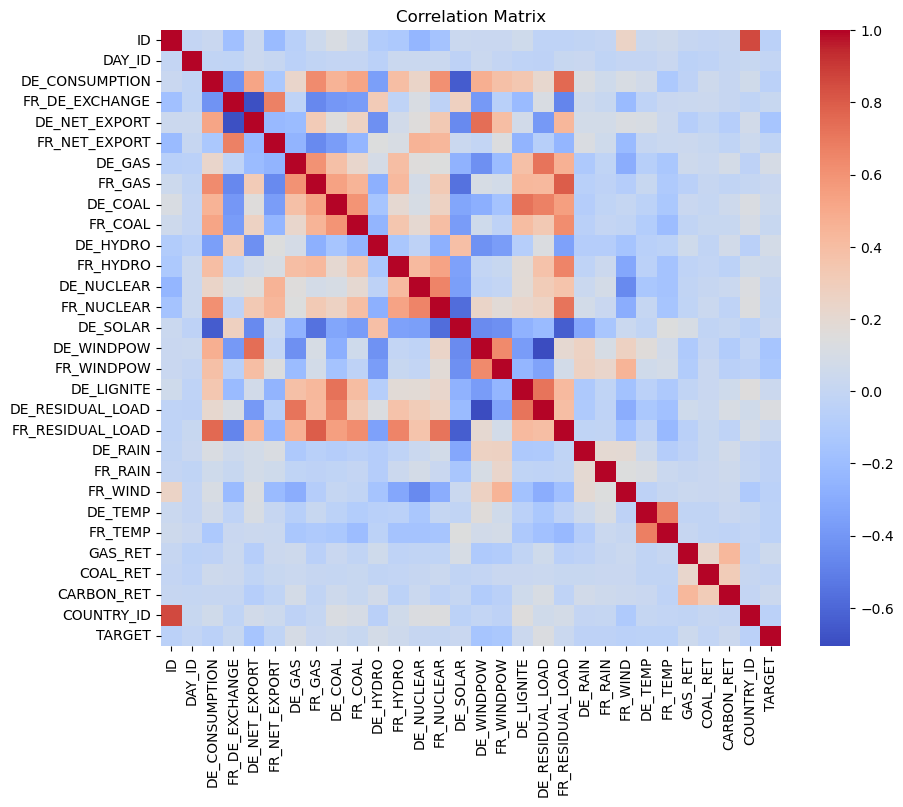

In [18]:
all_df_no_corr = all_df.drop(['FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'FR_SOLAR', 'DE_WIND'], axis=1)
correlation_matrix = all_df_no_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

There are no more correlations above 0.8 as we can see below.

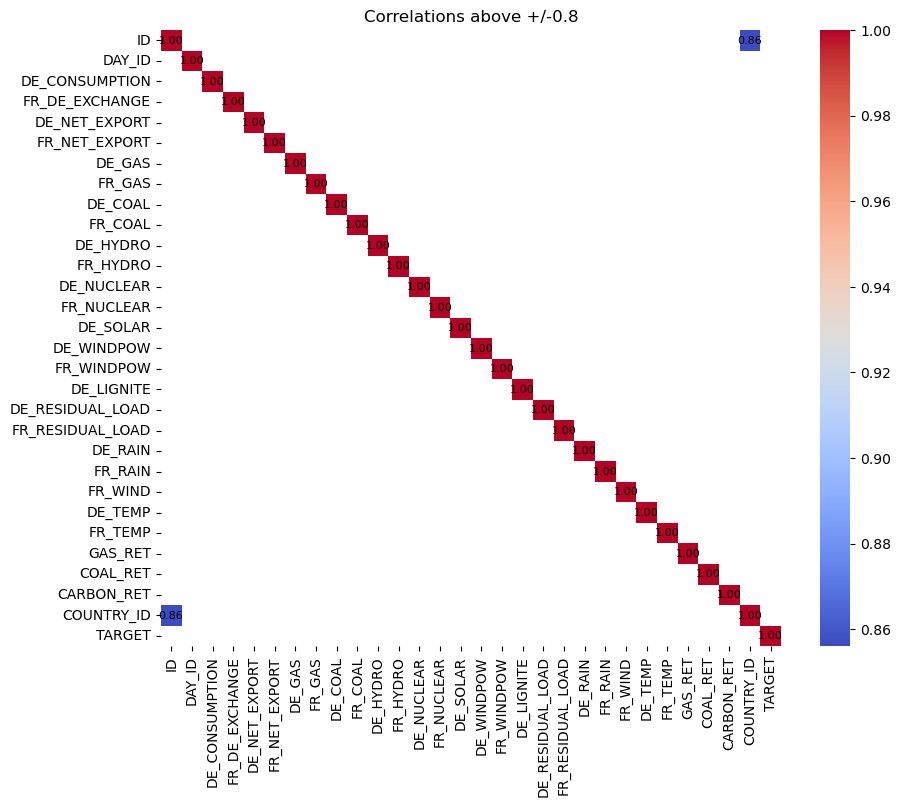

In [19]:
# Filter correlations above 0.8
high_correlations = correlation_matrix[correlation_matrix.abs() > 0.8]

plt.figure(figsize=(10, 8))
annot_kws = {"ha": 'center', "va": 'center', "fontsize": 8, "color": 'black'}
sns.heatmap(high_correlations, annot=True, cmap='coolwarm', fmt=".2f", annot_kws=annot_kws)
plt.title('Correlations above +/-0.8')
plt.show()

We need to drop the same columns from the test data.

In [20]:
X_test_merge = X_test_merge.drop(['FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'FR_SOLAR', 'DE_WIND'], axis=1)

## Model and train score

The benchark for this challenge consists in a simple linear regression, after a light cleaning of the data: The missing (NaN) values are simply filled with 0's and the `COUNTRY` column is dropped - namely we used the same model for France and Germany. 

### Baseline: Linear Regression - gabri

In [21]:
lr = LinearRegression()

X_train_clean = X_train.drop(['COUNTRY'], axis=1).fillna(0)
Y_train_clean = Y_train['TARGET']

lr.fit(X_train_clean, Y_train_clean)

output_train = lr.predict(X_train_clean)

def metric_train(output):

    return  spearmanr(output, Y_train_clean).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train) ))

Spearman correlation for the train set: 27.8%


The Spearman correlation obtained with our model on the train data set is about 27.9%.

NB: Electricity price variations can be quite volatile and this is why we have chosen the Spearman rank correlation as a robust metric for the challenge, instead of the more standard Pearson correlation.

### Model 1: Decision Trees - rhianne

### Model 2: Bagging

In [22]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [23]:
train_bagging = all_df_no_corr.copy()
X_bagging = train_bagging.drop(['TARGET', 'ID'], axis=1)
Y_bagging = train_bagging['TARGET']

In [24]:
X_bagging

,DAY_ID,DE_CONSUMPTION,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_ID
0,0,0.048418,0.079296,0.000000,0.650577,0.592572,-0.261565,0.534535,0.095197,1.312903,...,-0.344706,-0.987968,-0.856204,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,1
1,1,0.966997,-0.331356,0.405549,0.778627,1.111008,1.991028,0.660390,-0.786509,-0.681081,...,1.214288,-0.370990,-0.497520,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,1
2,2,-0.068972,1.102015,-1.080403,0.256736,1.228079,0.458302,-0.247704,-0.766904,1.785758,...,-0.540642,-0.344600,-0.372156,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1
3,3,-0.134670,1.051716,-1.881881,-0.612133,1.588542,0.069297,-0.635452,-0.718729,1.994144,...,-0.856321,-1.394561,-1.118297,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,1
4,5,-0.297850,-0.144615,-1.208286,-1.811403,1.059828,0.528273,-0.072071,-0.766063,1.275857,...,-0.552878,-1.374757,-0.790071,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,1202,-1.182561,1.201004,-1.616737,0.619501,-0.052984,-1.170735,-1.334403,-0.774620,0.109583,...,-1.359708,-0.085663,-0.997403,-0.777719,0.039450,1.411276,0.184767,0.257420,0.507079,0
1490,1207,1.002463,-0.651648,0.728817,-0.820640,0.321619,0.295393,-1.061328,-0.783923,0.086429,...,0.236243,-0.036193,0.009457,0.251640,0.005256,0.019393,0.099209,1.750872,0.646905,0
1491,1208,0.046568,-0.427976,-0.578391,-1.678101,1.391369,0.179728,0.069929,-0.758579,1.620765,...,-0.666261,-1.224735,2.661142,0.630211,1.065727,-1.439105,0.291714,0.568479,0.395742,0
1492,1212,-0.046100,0.270515,-0.137917,-0.789824,0.231723,0.625656,-0.491812,-0.776785,-0.441138,...,-0.589767,-0.039379,-0.237434,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,0


In [25]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_bagging, Y_bagging, test_size=0.2, random_state=42)

# Define the base regression model
base_model = DecisionTreeRegressor()
n_estimators = 10 
bagging_regressor = BaggingRegressor(base_model, n_estimators=n_estimators, random_state=42)

# Train the bagging regressor
bagging_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = bagging_regressor.predict(X_val)

Next, we do hyperparameter tuning.

In [26]:
param_grid = {
    'n_estimators': [5, 10, 15],
    'estimator__max_depth': [3, 5, 7],
    'estimator__min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(bagging_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = best_model.predict(X_val)

ValueError: Invalid parameter 'estimator' for estimator BaggingRegressor(base_estimator=DecisionTreeRegressor(), random_state=42). Valid parameters are: ['base_estimator', 'bootstrap', 'bootstrap_features', 'max_features', 'max_samples', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

We output metrics for the validation set.

In [ ]:
spearman_bagging = spearmanr(y_val, y_pred).correlation
print(f'Spearman Correlation for Bagging: {spearman_bagging}')

rmse_bagging = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'RMSE for Bagging: {rmse_bagging}')

Spearman Correlation for Bagging: 0.20417794722213384
RMSE for Bagging: 0.8029538525561614


And lastly we make predictions on the unseen data.

In [ ]:
X_test_merge = X_test_merge.drop('ID', axis=1)
y_pred_final = best_model.predict(X_test_merge)

### Model 3: Random Forest - rhianne

### Model 4: LightBGM- vivian

In [28]:
all_df_no_corr

,ID,DAY_ID,DE_CONSUMPTION,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,...,DE_RAIN,FR_RAIN,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_ID,TARGET
0,1057,0,0.048418,0.079296,0.000000,0.650577,0.592572,-0.261565,0.534535,0.095197,...,-0.987968,-0.856204,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,1,0.108953
1,1179,1,0.966997,-0.331356,0.405549,0.778627,1.111008,1.991028,0.660390,-0.786509,...,-0.370990,-0.497520,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,1,-0.063369
2,1327,2,-0.068972,1.102015,-1.080403,0.256736,1.228079,0.458302,-0.247704,-0.766904,...,-0.344600,-0.372156,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1,2.575976
3,2016,3,-0.134670,1.051716,-1.881881,-0.612133,1.588542,0.069297,-0.635452,-0.718729,...,-1.394561,-1.118297,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,1,0.068905
4,2047,5,-0.297850,-0.144615,-1.208286,-1.811403,1.059828,0.528273,-0.072071,-0.766063,...,-1.374757,-0.790071,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870,1,1.031308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,282,1202,-1.182561,1.201004,-1.616737,0.619501,-0.052984,-1.170735,-1.334403,-0.774620,...,-0.085663,-0.997403,-0.777719,0.039450,1.411276,0.184767,0.257420,0.507079,0,-0.091774
1490,505,1207,1.002463,-0.651648,0.728817,-0.820640,0.321619,0.295393,-1.061328,-0.783923,...,-0.036193,0.009457,0.251640,0.005256,0.019393,0.099209,1.750872,0.646905,0,-1.324555
1491,823,1208,0.046568,-0.427976,-0.578391,-1.678101,1.391369,0.179728,0.069929,-0.758579,...,-1.224735,2.661142,0.630211,1.065727,-1.439105,0.291714,0.568479,0.395742,0,0.060380
1492,771,1212,-0.046100,0.270515,-0.137917,-0.789824,0.231723,0.625656,-0.491812,-0.776785,...,-0.039379,-0.237434,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,0,-0.144320


In [29]:
#sepreate the data into train and val for binary classification
from sklearn.model_selection import train_test_split
traindata_lgb = all_df_no_corr.copy()
Y_train = traindata_lgb['TARGET']
traindata_lgb = traindata_lgb.drop(['ID','TARGET'], axis=1)
X_train_lgb, X_val_lgb, Y_train_lgb, Y_val_lgb = train_test_split(traindata_lgb, Y_train, test_size=0.2, random_state=42)



In [30]:
import lightgbm as lgb
from math import sqrt
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_lgb, Y_train_lgb)

params = {
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

lgbm = lgb.train(params, lgb_train, num_boost_round=100)
output_train_lgb = lgbm.predict(X_val_lgb)

def rmse(output, Y_val_lgb):
    return sqrt(mean_squared_error(output, Y_val_lgb))

print('RMSE for the lightgbm model for encoded data: {:.1f}'.format(rmse(output_train_lgb, Y_val_lgb)))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6883
[LightGBM] [Info] Number of data points in the train set: 1195, number of used features: 28
[LightGBM] [Info] Start training from score 0.105927
RMSE for the lightgbm model for encoded data: 0.9


In [31]:
def metric_train(output,val):

    return  spearmanr(output, val).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train_lgb,Y_val_lgb) ))

Spearman correlation for the train set: 22.3%


In [34]:
#Make the prediction using X_test and lgbm
#drop the ID for X_test_merge
X_test_merge = X_test_merge.drop('ID', axis=1)
result_lgbm = lgbm.predict(X_test_merge)

result_df = pd.DataFrame(result_lgbm, columns=['TARGET'])

#add the ID of test data to the result_df
result_df['ID'] = X_test['ID']
result_df = result_df[['ID', 'TARGET']]

# result_df.to_csv('result_lgb.csv', index=False)

In [ ]:
# #grid search for the best parameter
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'num_leaves': [31, 50, 100, 200],
#     'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5],
#     'feature_fraction': [0.9, 0.8, 0.7, 0.6, 0.5],
# }

# gbm_grid = lgb.LGBMRegressor(objective='regression', metric='l2')
# grid_mse = GridSearchCV(estimator=gbm_grid, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
# grid_mse.fit(X_train_lgb, Y_train_lgb)

# print("Best parameters found: ", grid_mse.best_params_)
# print("Lowest RMSE found: ", sqrt(-grid_mse.best_score_))

### Model 5: Gradient Boosted Trees - gabri

### Model 6: AdaBoost - alix

### Model 7: XGBoost - vivian

In [37]:
#train a xgboost model using binary country 
import xgboost as xgb

params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10,
    'n_estimators': 10
}

xg_reg = xgb.XGBRegressor(**params)
xg_reg.fit(X_train_lgb, Y_train_lgb)

output_train_xgb = xg_reg.predict(X_val_lgb)
print('RMSE for the xgboost model: {:.1f}'.format(rmse(output_train_xgb, Y_val_lgb)))
print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train_xgb,Y_val_lgb) ))

RMSE for the xgboost model: 0.8
Spearman correlation for the train set: 14.7%


In [36]:
# #grid search for the best parameter
# param_grid = {
#     'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
#     'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5],
#     'max_depth': [3, 5, 7, 9],
#     'alpha': [10, 20, 30, 40],
# }

# xg_reg_xggrid = xgb.XGBRegressor(objective='reg:squarederror')
# grid_mse_xgb = GridSearchCV(estimator=xg_reg_xggrid, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
# grid_mse_xgb.fit(X_train_lgb, Y_train_lgb)

# print("Best parameters found: ", grid_mse_xgb.best_params_)
# print("Lowest RMSE found: ", sqrt(-grid_mse_xgb.best_score_))


In [42]:
#Make the prediction using X_test and xg_reg
result = xg_reg.predict(X_test_merge)

result_df = pd.DataFrame(result, columns=['TARGET'])

#add the ID of test data to the result_df
result_df['ID'] = X_test['ID']
result_df = result_df[['ID', 'TARGET']]

# result_df.to_csv('result_xgb.csv', index=False)

## Generate the benchmark output

Next, we process the test set the same way as we did on the train set and predict using our linear model, while saving the predictions to a csv file satisfying the challenge output contraints.


## Tips and ideas for improvements 

- Thinking about the fundamental price drivers of electricity in each country may be useful. 

- The dataset is small, so you will need to be careful not to overfit your models. It will be useful to use good crossvalidation practices. 
